# 6. Investigating the impact of warming on model predictions
## Forecasting Crop Yields on a national scale (FACYnation)

### by Raphael Shirley (University of Sussex)

In this notebook we take the previous model and investigate increases in temperature.

## Investigating impact of temperature increases

In this notebook we take the two dimensional Gaussian fitted to the regional data and check for the impact of temperature increases which should depend on where current temperatures lie with respect to the peak yield response.









## Rerun model from notebook 3
First lets generate the same set of samples from the posterior.

In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import pystan

from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

from xidplus.stan_fit import stan_utility

%matplotlib inline


## Compute the productivity trend and find a final baseline

In [2]:
yields_for_comp = pd.read_table('./Crop_data_files/Maize_yield_obs_timeseries.csv', sep=',')
anoms_for_comp = pd.read_table('./Crop_data_files/Maize_median_yield_anoms.csv')

In [3]:
states = ['Indiana', 'Illinois', 'Ohio', 'Nebraska', 'Iowa', 'Minnesota']
state = 'Nebraska'

years = np.arange(1960, 2008)
anoms_by_year = [anoms_for_comp[anoms_for_comp['Region'] == 'Maize_Spring_USA_{}'.format(state)][str(year)].iloc[0] 
                 for year in years]
yields_by_year = [yields_for_comp[yields_for_comp['Region'] == 'Maize_Spring_USA_{}'.format(state)][str(year)].iloc[0] 
                 for year in years]

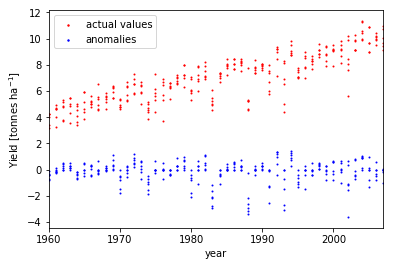

In [4]:
fig, ax = plt.subplots()


for state in states:
    anoms_by_year = [anoms_for_comp[anoms_for_comp['Region'] == 'Maize_Spring_USA_{}'.format(state)][str(year)].iloc[0] 
                 for year in years]
    yields_by_year = [yields_for_comp[yields_for_comp['Region'] == 'Maize_Spring_USA_{}'.format(state)][str(year)].iloc[0] 
                 for year in years]
    
    plt.scatter(years, anoms_by_year, s = 1.0, c ='b')
    plt.scatter(years, yields_by_year, s = 1.0, c ='r')
    
plt.scatter([-1], [0], s = 2.0, c ='r', label = 'actual values')
plt.scatter([-1], [0], s = 2.0, c ='b', label = 'anomalies')

ax.set_xlabel('year')
ax.set_ylabel('Yield [tonnes ha$^{-1}$]')
ax.set_xlim(1960, 2007)
plt.legend()

plt.savefig("./figs/yields_vs_anoms_noline.png")
plt.savefig("./figs/yields_vs_anoms_noline.pdf")

In [5]:
all_anoms = np.array([])
all_yields = np.array([])
all_years = np.array([])
for state in states:
    anoms_by_year = [anoms_for_comp[anoms_for_comp['Region'] == 'Maize_Spring_USA_{}'.format(state)][str(year)].iloc[0] 
                 for year in years]
    yields_by_year = [yields_for_comp[yields_for_comp['Region'] == 'Maize_Spring_USA_{}'.format(state)][str(year)].iloc[0] 
                 for year in years]
    all_yields = np.hstack([all_yields, yields_by_year])
    all_anoms = np.hstack([all_anoms, anoms_by_year])
    all_years = np.hstack([all_years, years])

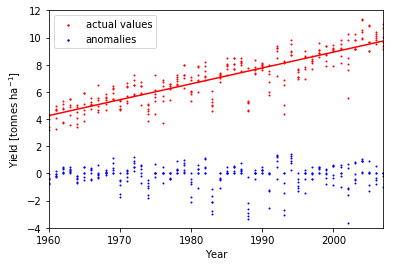

In [6]:
fig, ax = plt.subplots()


import scipy
slope, intercept, rval, pval, sterr = scipy.stats.linregress(all_years, all_yields)

x = np.array([1950., 2020.])
y = slope * x + intercept
plt.plot(x, y, c ='r')
    
plt.scatter( all_years,  all_anoms, s = 1.0, c ='b')
plt.scatter( all_years,  all_yields, s = 1.0, c ='r')
    
plt.scatter([-1], [0], s = 2.0, c ='r', label = 'actual values')
plt.scatter([-1], [0], s = 2.0, c ='b', label = 'anomalies')

ax.set_xlabel('Year')
ax.set_ylabel('Yield [tonnes ha$^{-1}$]')
ax.set_xlim(1960, 2007)
ax.set_ylim(-4, 12)
plt.legend()

plt.savefig("./figs/yields_vs_anoms.png")
plt.savefig("./figs/yields_vs_anoms.pdf")

In [7]:
print('predicted value in 2019 is {}'.format(slope * 2019 + intercept) )
print('latest value in 2007 is {}'.format(slope * 2007 + intercept) )

predicted value in 2019 is 11.151293266210757
latest value in 2007 is 9.748564345238123


In [8]:
all_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
months = all_months[3:9]

In [9]:
def take_mean_anom(table):
    means_by_year = []
    for year in np.arange(1980, 2008):
        means_by_year.append(np.mean(
            [table[str(month)][table['Unnamed: 0'] ==  year].iloc[0]  for month in months ]
        ) )
    return np.array(means_by_year)
    
precip_mean_anoms = np.array([])
temp_mean_anoms   = np.array([])
yields_from_1980  = np.array([])

for state in states:
    precip_month_anoms = pd.read_table(
        'Crop_data_files/maize_met_anoms/Maize_Spring_USA_{}_precip_anom_real.csv'.format(state))
    temp_month_anoms = pd.read_table(
        'Crop_data_files/maize_met_anoms/Maize_Spring_USA_{}_temp_anom_real.csv'.format(state))

    precip_mean_anoms = np.hstack([precip_mean_anoms,
                                   take_mean_anom(precip_month_anoms)])
    temp_mean_anoms = np.hstack([temp_mean_anoms,
                                 take_mean_anom(temp_month_anoms)])
    yields_from_1980 = np.hstack([ yields_from_1980,
                                  ([yields_for_comp[
                                      yields_for_comp['Region'] == 'Maize_Spring_USA_{}'.format(state)
                                  ][str(year)].iloc[0] 
                 for year in np.arange(1980, 2008)]) 
                                 ])
    


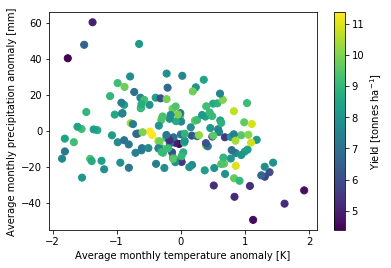

In [10]:
# Scatter plot of the sources.
fig, axis = plt.subplots()


im = axis.scatter(temp_mean_anoms, 
                  precip_mean_anoms, 
                  c=yields_from_1980,  
                  cmap="viridis",
                  s=50.0,
                 alpha = 1.)#vmin=0.0, vmax=360.,
axis.set_xlabel("Average monthly temperature anomaly [K]")
axis.set_ylabel("Average monthly precipitation anomaly [mm]")
#axis.axis('equal')

cbar = fig.colorbar(im) # adding the colobar on the right
cbar.set_label('Yield [tonnes ha$^{-1}$]')
# Optionally add a colorbar
#cax, _ = mpl.colorbar.make_axes(ax)
#cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap)


plt.savefig('./figs/real_data_scatter.pdf', bbox_inches='tight')
plt.savefig('./figs/real_data_scatter.png', bbox_inches='tight')

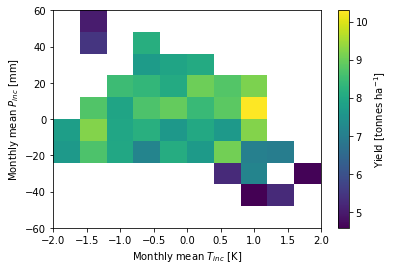

In [11]:
fig, ax = plt.subplots()


test = np.full([10, 10], np.nan)

ts = np.linspace(-2,2, 10)
ps = np.linspace(-60,60, 10)

t_width = np.absolute(ts[1] - ts[0])
p_width = np.absolute(ps[1] - ps[0])

X,Y = meshgrid(ts, ps) # grid of point

def z_func(X,Y):
    in_bin = temp_mean_anoms > (X - t_width/2)
    in_bin = np.bitwise_and(in_bin , temp_mean_anoms < (X + t_width/2) )
    in_bin = np.bitwise_and(in_bin , precip_mean_anoms > (Y - p_width/2) )
    in_bin = np.bitwise_and(in_bin , precip_mean_anoms < (Y + p_width/2) )
    yields_temp = in_bin*yields_from_1980
    yields_temp[np.isclose(yields_temp , 0)] = np.nan
    return np.nanmean(yields_temp)


z_func = np.vectorize(z_func)
#Lets use the median

Z = z_func(X, Y)

im = imshow(np.flip(Z, axis=0),cmap="viridis", 
            extent=[ts[0],ts[-1] ,ps[0], ps[-1]],
            aspect="auto") # drawing the function
# adding the Contour lines with labels
#cset = contour(Z,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2)
#clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
cbar = colorbar(im) # adding the colobar on the right
cbar.set_label('Yield [tonnes ha$^{-1}$]')
# latex fashion title
#title('$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$')

ax.set_xlabel('Monthly mean $T_{inc}$ [K]')
ax.set_ylabel('Monthly mean $P_{inc}$ [mm]')

plt.savefig('./figs/real_data_hist.pdf', bbox_inches='tight')
plt.savefig('./figs/real_data_hist.png', bbox_inches='tight')

In [12]:

for state in states:
    precip_month_anoms = pd.read_table(
        'Crop_data_files/maize_met_anoms/Maize_Spring_USA_{}_precip_anom_real.csv'.format(state))
    temp_month_anoms = pd.read_table(
        'Crop_data_files/maize_met_anoms/Maize_Spring_USA_{}_temp_anom_real.csv'.format(state))
    
    yields_by_year = [yields_for_comp[yields_for_comp['Region'] == 'Maize_Spring_USA_{}'.format(state)
                                     ][str(year)].iloc[0] 
                 for year in years]
    
    #temp_mean =  np.nanmean(np.array(temp_month_anoms[all_months]))
    temp_variance = np.nanstd(np.array(temp_month_anoms[all_months])) 
    #precip_mean =  np.nanmean(np.array(precip_month_anoms[all_months]))
    precip_variance = np.nanstd(np.array(precip_month_anoms[all_months])) 
    yield_variance = np.nanstd(np.array(yields_by_year)) 
    
    print("{} & {} & {} & {} \\\\ ".format(state, 
                                 #round(temp_mean, 2), 
                                 round(temp_variance, 2), 
                                 #round(precip_mean, 2),
                                 round(precip_variance, 2),
                                 round(yield_variance, 2)
                                     )
         )

Indiana & 1.93 & 35.25 & 1.68 \\ 
Illinois & 2.02 & 36.39 & 1.78 \\ 
Ohio & 1.87 & 31.05 & 1.67 \\ 
Nebraska & 2.21 & 30.9 & 1.95 \\ 
Iowa & 2.23 & 33.55 & 1.92 \\ 
Minnesota & 2.39 & 29.06 & 2.06 \\ 


In [13]:
yields_by_year

[3.38904,
 4.048019999999999,
 3.7342199999999997,
 4.33044,
 3.64008,
 3.82836,
 4.76976,
 4.51872,
 5.146319999999999,
 5.46012,
 5.3346,
 5.20908,
 5.83668,
 5.83668,
 3.89112,
 4.3932,
 3.70284,
 6.276,
 6.52704,
 6.276,
 6.08772,
 6.9036,
 7.091880000000001,
 5.27184,
 6.715319999999999,
 7.2174,
 7.65672,
 7.97052,
 4.64424,
 7.845,
 7.78224,
 7.5312,
 7.15464,
 4.3932,
 8.91192,
 7.468439999999999,
 7.845,
 8.28432,
 9.60228,
 9.414,
 9.1002,
 8.1588,
 9.85332,
 9.16296,
 9.97884,
 10.92024,
 10.10436,
 9.16296]

In [14]:
precip_month_anoms = pd.read_table(
        'Crop_data_files/maize_met_anoms/Maize_Spring_USA_{}_precip_anom_real.csv'.format(state))
np.array(precip_month_anoms[all_months])

array([[  7.04357383,  -3.49763475, -22.64754188, -55.05743983,
        -29.40544654,  -9.16025199, -43.60732175,  81.16157186,
         14.75415008, -25.40226811, -24.22793364,  -7.81111636],
       [ -6.54554422,  18.68405776,  -5.26810127,  -0.30902153,
        -36.18021167,  23.29038607,  14.99584592,  25.03589283,
        -48.88323717,  17.31911413, -14.13875667,  -3.36095884],
       [  2.00493247,  -6.95511034,  -8.00935947, -33.54022235,
         38.44451158, -58.33524483,   0.67849683,  -8.13566772,
         15.20244632,  34.96313155,  33.06978919,  26.98527072],
       [  2.03839958,  -2.64086805,  14.88356838, -27.39703391,
         -3.60715643,  16.24437972, -15.62137768,  -9.96020125,
          9.31834654,   3.89175307,  33.48001108,  -7.91115338],
       [ -2.1079126 ,  11.12650188, -18.08212931,  24.28584145,
        -19.45655228,  68.7699285 , -29.59731297, -32.1375665 ,
        -22.40299604,  73.01998064,  -2.55428164,  14.99461405],
       [ -5.7040543 ,  -4.09335594,

## Rerun the full models

In [15]:
# Read in climate temperatures
clim_temp_maize=pd.read_table('./Crop_data_files/clim_file/temp_climatology_Maize.csv')
clim_temp_maize.rename(columns = {'Unnamed: 0':'Crop_season_location'}, inplace = True)
# Read in climate precipitation
clim_precip_maize=pd.read_table('./Crop_data_files/clim_file/precip_climatology_Maize.csv')
clim_precip_maize.rename(columns = {'Unnamed: 0':'Crop_season_location'}, inplace = True)
# Read in Yields
yields=pd.read_table('./Crop_data_files/Maize_median_yield_anoms.csv')

In [16]:
states=['Indiana','Illinois', 'Ohio','Nebraska', 'Iowa','Minnesota']

In [17]:
#Read in and add back mean temperature to get real temperature values
temp_states=[]
for i,s in enumerate(states):
    maize_temp=pd.read_table('./Crop_data_files/maize_met_anoms/Maize_Spring_USA_'
                             +s+'_temp_anom_real.csv')
    maize_temp.rename(columns = {'Unnamed: 0':'Year'}, inplace = True)
    tmp=maize_temp.iloc[:,1:].add(clim_temp_maize[
        clim_temp_maize['Crop_season_location']== 'Maize_Spring_USA_'+states[0]
                                                 ].iloc[0,1:,])
    temp_states.append(tmp)
temp_states=pd.concat(temp_states,keys=states)

#Read in and add back mean precipitation to get real precipitation values
precip_states=[]
for i,s in enumerate(states):
    maize_precip=pd.read_table('./Crop_data_files/maize_met_anoms/Maize_Spring_USA_'
                               +s+'_precip_anom_real.csv')
    maize_precip.rename(columns = {'Unnamed: 0':'Year'}, inplace = True)
    tmp=maize_precip.iloc[:,1:].add(clim_precip_maize[
        clim_precip_maize['Crop_season_location']== 'Maize_Spring_USA_'+states[0]
                                                     ].iloc[0,1:,])
    precip_states.append(tmp)
precip_states=pd.concat(precip_states,keys=states)

In [18]:
n_years=np.array(yields[yields['Region']=='Maize_Spring_USA_Indiana'].iloc[0,22:]).size
data2={
    'n_regions':len(states),
    'n_years':n_years,
    'd_temp':np.array(temp_states.iloc[:,3:9]).reshape(
                     len(states),
                     np.int(np.array(temp_states.iloc[:,3:9]).shape[0]/len(states)),6
                                                      ).astype(float),
    'd_precip':np.array(precip_states.iloc[:,3:9]).reshape(
                     len(states),
                     np.int(np.array(precip_states.iloc[:,3:9]).shape[0]/len(states)),6
                                                      ).astype(float),
    'd_yields':np.array(yields[yields["Region"].isin(
                     ['Maize_Spring_USA_'+s for s in states]
                                                    )].iloc[:,22:]).astype(float)+9.75,
    'n_gf':40,
    'temp':np.arange(0,40,1),
    'precip':np.arange(0,200,5)

}

In [19]:

gm2 = pystan.StanModel(file='./stan/2d-gaussian.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_889b1084947e1d379c9ef129719d74d2 NOW.


In [20]:

fit=gm2.sampling(data=data2,chains=4,iter=1000,verbose=True,seed=1308)

In [21]:

fit

Inference for Stan model: anon_model_889b1084947e1d379c9ef129719d74d2.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_t               18.66    0.03   0.78  17.04  18.15  18.68  19.22  20.12    891    1.0
sigma_t             7.16    0.02   0.58   6.06   6.74   7.13   7.55   8.32    997    1.0
mu_p              114.47    0.09   3.38 108.07 112.23  114.4 116.66 121.26   1413    1.0
sigma_p            75.01    0.07   2.62  70.18  73.14  74.85  76.87  80.21   1505    1.0
norm                 2.2  1.8e-3   0.05    2.1   2.16    2.2   2.24   2.31    974    1.0
fdy1[0]             0.08  1.8e-3   0.06   0.01   0.04   0.07   0.11   0.23    999    1.0
fdy1[1]             0.12  2.3e-3   0.07   0.02   0.06    0.1   0.15    0.3    993    1.0
fdy1[2]             0.16  2.9e-3   0.09   0.03   0.09   0.14   0.21   0.38    986    1.0
fdy1[3]     

In [22]:

# carry out some diagnostic checks on fit

stan_utility.check_div(fit)
stan_utility.check_energy(fit)
stan_utility.check_treedepth(fit)

0.0 of 2000 iterations ended with a divergence (0.0%)
0 of 2000 iterations saturated the maximum tree depth of 10 (0.0%)


In [23]:
samples=fit.extract()

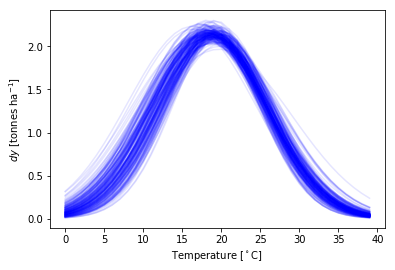

In [24]:
#plt.figure(figsize=(10,10))
for i in range(0,2000,10):
    plt.plot(fit.data['temp'],samples['fdy1'][i,:],alpha=0.1, c='b')
plt.xlabel('Temperature [$^\circ$C]')
plt.ylabel(r'$dy$ [tonnes ha$^{-1}$]')

plt.savefig('./figs/2d_Gauss_temp_post_sample_growth_curve.pdf')
plt.savefig('./figs/2d_Gauss_temp_post_sample_growth_curve.png')
#plt.title('Growth Curve')

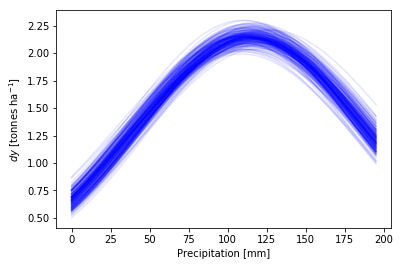

In [25]:
for i in range(0,2000,10):
    plt.plot(fit.data['precip'],samples['fdy2'][i,:],alpha=0.1, c='b')
plt.xlabel('Precipitation [mm]')
plt.ylabel(r'$dy$ [tonnes ha$^{-1}$]')
plt.savefig('./figs/2d_Gauss_precip_post_sample_growth_curve.pdf')
plt.savefig('./figs/2d_Gauss_precip_post_sample_growth_curve.png')

## Compute a sample of region averaged yield anomalies for each posterior sample

We have a sample from the posterior on the Gaussian parameters $\boldsymbol \theta_i$. For each sample, $i$, we want to compute the mean yield anomaly for all the regions combined at a given temperature increment $\Delta T_j$ applied to every tru temperature. After this procedure we will have a sample of mean yield anomalies $Y_i_j$ for each temperature increase.

In [26]:
def yield_anomaly(temp_6m, precip_6m, mu_t, sigma_t, mu_p, sigma_p, norm):
    """Take six months of T and P and return yield for given params.
    
    This should be identical to the function in the STAN model
    """
    if len(norm) == 1:
        norm = norm * np.ones(6)
    dy = np.zeros(6)
    for month in np.arange(6):
        dy[month] = norm[month]*np.exp(-0.5 *( np.square((temp_6m[month]    - mu_t)/sigma_t) 
                                             + np.square((precip_6m[month] - mu_p)/sigma_p) )
                                      )
    return np.sum(dy)


def compute_mean_yield_anomaly(T_inc, data, mu_t, sigma_t, mu_p, sigma_p, norm):
    """ Compute mean yield anomaly for a model over regions and years
    
    The function yield_anomaly returens the yield anomaly for a year 
    and and region. Here we loop over the regions and years to create
    and overall mean.
    
    """
    
    yield_anomalies = np.full((6, 35), np.nan)
    #loop over states
    for state in np.arange(6):
        #loop over years
        for year in np.arange(35):
            temp_6m = data['d_temp'][state, year, :] + T_inc
            precip_6m = data['d_precip'][state, year, :]
            yield_anomalies[state, year] = yield_anomaly(temp_6m, precip_6m, mu_t, sigma_t, mu_p, sigma_p, norm)
    
    return np.nanmean(yield_anomalies)


compute_mean_yield_anomaly(1., data2, 19.71, 5.23, 114.69, 62.41, [1.56])    

5.630036266199637

In [27]:
%%timeit
compute_mean_yield_anomaly(1., data2, 20., 5., 120., 65., [1.5]) 

15 ms ± 322 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
(200000* 14.e-3)/(60)

46.666666666666664

There are six regions each with 35 years with six months. We want the total average for each parameter set and temperature increase.

In [29]:
T_incs = np.linspace(-5, 5, 50)

In [30]:
np.zeros((len(samples['mu_t']), len(T_incs))).shape

(2000, 50)

In [31]:
mean_yield_samples =  np.zeros((len(samples['mu_t']), len(T_incs)))

#Loop over the samples and for each parameter realisation
#TODO: Vectorise to speed up

for n in np.arange(len(samples['mu_t'])):
    
    mu_t    = samples['mu_t'][n]
    sigma_t = samples['sigma_t'][n]
    mu_p    = samples['mu_p'][n]
    sigma_p = samples['sigma_p'][n]
    norm    = [samples['norm'][n]]
    for m, T_inc in enumerate(T_incs):
        mean_yield_samples[n, m] = compute_mean_yield_anomaly(T_inc, data2, mu_t, sigma_t, mu_p, sigma_p, norm)

In [32]:
len(mean_yield_samples.T[0])

2000

In [33]:
sample_means   = [np.mean(s) for s in mean_yield_samples.T]
sample_medians = [np.median(s) for s in mean_yield_samples.T]
sample_25      = [np.percentile(s, 25.) for s in mean_yield_samples.T]
sample_75      = [np.percentile(s, 75.)  for s in mean_yield_samples.T]

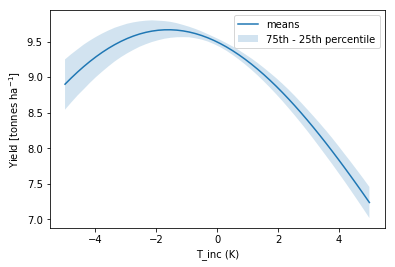

In [34]:

plt.plot(T_incs, sample_means, label='means')
#plt.plot(T_incs, sample_medians, label='medians')
#plt.plot(T_incs, sample_25, label='25th percentile')
#plt.plot(T_incs, sample_75, label='75th percentile')
plt.fill_between(T_incs, sample_25, sample_75, label='75th - 25th percentile', alpha=0.2)
plt.legend()
plt.xlabel('T_inc (K)')
plt.ylabel('Yield [tonnes ha$^{-1}$]')
plt.savefig('./figs/temperature_impact.pdf')
plt.savefig('./figs/temperature_impact.png')

(array([  2.,   9.,  16.,  30.,  61.,  96., 158., 171., 235., 254., 231.,
        208., 182., 133.,  95.,  62.,  27.,  20.,   7.,   3.]),
 array([8.48109329, 8.52893474, 8.5767762 , 8.62461765, 8.67245911,
        8.72030056, 8.76814202, 8.81598347, 8.86382493, 8.91166638,
        8.95950784, 9.00734929, 9.05519075, 9.1030322 , 9.15087366,
        9.19871511, 9.24655657, 9.29439802, 9.34223948, 9.39008093,
        9.43792239]),
 <a list of 20 Patch objects>)

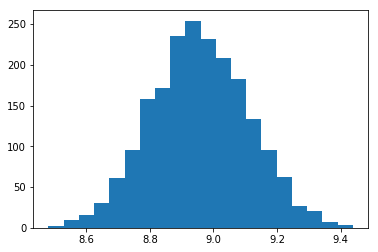

In [35]:
plt.hist(mean_yield_samples.T[33], 20)

(array([  2.,   3.,  16.,  31.,  60.,  83., 166., 211., 236., 267., 252.,
        223., 176., 119.,  86.,  39.,  19.,   9.,   0.,   2.]),
 array([ 7.2101904 ,  7.38397627,  7.55776214,  7.73154801,  7.90533387,
         8.07911974,  8.25290561,  8.42669148,  8.60047735,  8.77426322,
         8.94804908,  9.12183495,  9.29562082,  9.46940669,  9.64319256,
         9.81697843,  9.99076429, 10.16455016, 10.33833603, 10.5121219 ,
        10.68590777]),
 <a list of 20 Patch objects>)

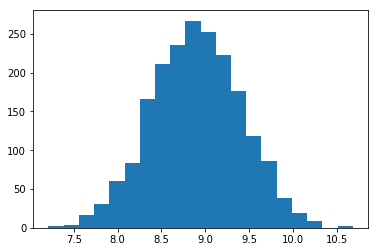

In [36]:
plt.hist(mean_yield_samples.T[0], 20)

This clearly shows that the model predicts reductions in yields as a consequence of raising temperatures.

## Make a two dimensional plot of the function on one posterior

We want to see how the function 

In [37]:
# Posterior sample
#                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
#mu_t               19.71    0.02   0.68  18.17  19.29  19.77  20.19  20.87   1205    1.0
#sigma_t             5.23    0.02   0.58   4.26    4.8   5.17    5.6   6.49    795    1.0
#mu_p              114.69    0.11   4.26 106.07 111.81 114.87 117.65 122.71   1571    1.0
#sigma_p            62.41    0.07   2.76  57.16  60.51  62.41  64.24   67.9   1633    1.0
#norm                1.56  2.3e-3   0.07   1.43   1.51   1.56    1.6    1.7    862    1.0

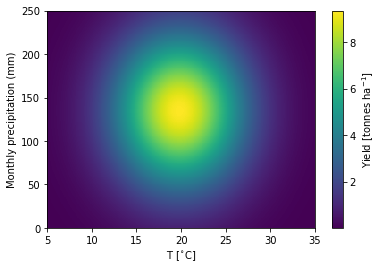

In [38]:


fig, ax = plt.subplots()

t1, t2 = 5., 35.
p1, p2 = 0., 250.
x = arange(t1,t2,.1)
y = arange(p1,p2,1.)
X,Y = meshgrid(x, y) # grid of point
def yield_equal(temp, precip, mu_t, sigma_t, mu_p, sigma_p, norm):
    """Take six months of T and P and return yield for given params.
    
    This should be identical to the function in the STAN model
    """
    temp_6m = np.full(6, temp)
    precip_6m = np.full(6, precip)
    if len(norm) == 1:
        norm = norm * np.ones(6)
    dy = np.zeros(6)
    for month in np.arange(6):
        dy[month] = norm[month]*np.exp(-0.5 *( np.square((temp_6m[month]    - mu_t)/sigma_t) 
                                             + np.square((precip_6m[month] - mu_p)/sigma_p) )
                                      )
    return np.sum(dy)
def z_func(X,Y):
    return yield_equal(X, Y, 19.77, 5.17, 114.87, 62.41, [1.56])
z_func = np.vectorize(z_func)
#Lets use the median

Z = z_func(X, Y) # evaluation of the function on the grid

im = imshow(Z,cmap="viridis", extent=[t1,t2,p1,p2], aspect="auto") # drawing the function
# adding the Contour lines with labels
#cset = contour(Z,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2)
#clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
cbar = fig.colorbar(im) # adding the colobar on the right
cbar.set_label('Yield [tonnes ha$^{-1}$]')
# latex fashion title
#title('$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$')

ax.set_xlabel('T [$^{\circ}$C]')
ax.set_ylabel('Monthly precipitation (mm)')

plt.savefig('./figs/2d_yield_response.pdf')
plt.savefig('./figs/2d_yield_response.png')

## Include correlation

We originally ran a zero correlated gaussian, now let's incldue correlation


In [39]:
gm3 = pystan.StanModel(file='./stan/2d-gaussian_with_correlation.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2df05908660c977a9152ef2888fc2e93 NOW.


In [40]:
fit2=gm3.sampling(data=data2,chains=4,iter=1000,verbose=True,seed=1308)

In [41]:
# carry out some diagnostic checks on fit

stan_utility.check_div(fit2)
stan_utility.check_energy(fit2)
stan_utility.check_treedepth(fit2)

0.0 of 2000 iterations ended with a divergence (0.0%)
0 of 2000 iterations saturated the maximum tree depth of 10 (0.0%)


In [42]:
samples2=fit2.extract()

In [43]:
fit2

Inference for Stan model: anon_model_2df05908660c977a9152ef2888fc2e93.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_t               18.64    0.02   0.81  16.95  18.12  18.71  19.17  20.15   1303    1.0
sigma_t             7.13    0.02   0.58   6.03   6.72    7.1   7.51   8.28   1206    1.0
mu_p              115.15    0.09   3.42 108.26 112.88 115.18 117.41  121.6   1372    1.0
sigma_p            74.98    0.06   2.58  69.99  73.28  74.98  76.69   80.0   1933    1.0
rho                -0.05  1.4e-3   0.06  -0.15  -0.08  -0.05-8.3e-3   0.06   1573    1.0
norm                 2.2  1.6e-3   0.06    2.1   2.17    2.2   2.24   2.32   1241    1.0
fdy1[0]             0.08  1.7e-3   0.06   0.01   0.04   0.07   0.11   0.23   1213    1.0
fdy1[1]             0.11  2.1e-3   0.07   0.02   0.06    0.1   0.15   0.29   1210    1.0
fdy1[2]     

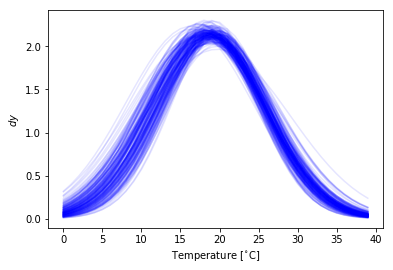

In [44]:
#plt.figure(figsize=(10,10))
for i in range(0,2000,10):
    plt.plot(fit2.data['temp'],samples['fdy1'][i,:],alpha=0.1, c='b')
plt.xlabel('Temperature [$^{\circ}$C]')
plt.ylabel(r'$dy$')
#plt.title('Growth Curve')
plt.savefig('./figs/growth_curve.pdf')
plt.savefig('./figs/growth_curve.png')

In [45]:
def yield_anomaly2(temp_6m, precip_6m, mu_t, sigma_t, mu_p, sigma_p, rho, norm):
    """Take six months of T and P and return yield for given params.
    
    This should be identical to the function in the STAN model
    """
    if len(norm) == 1:
        norm = norm * np.ones(6)
    dy = np.zeros(6)
    for month in np.arange(6):
        dy[month] = norm[month]*np.exp(-(1/(2 - 2*rho**2)) *( np.square((temp_6m[month]    - mu_t)/sigma_t) 
                                                           + np.square((precip_6m[month] - mu_p)/sigma_p) 
                                                           - (2*rho*(temp_6m[month]    - mu_t)
                                                                   *(precip_6m[month] - mu_p)
                                                             )
                                                              /(sigma_t*sigma_p)
                                                           )
                                      )
                                      
    return np.sum(dy)


def compute_mean_yield_anomaly2(T_inc, data, mu_t, sigma_t, mu_p, sigma_p, rho, norm):
    """ Compute mean yield anomaly for a model over regions and years
    
    The function yield_anomaly returens the yield anomaly for a year 
    and and region. Here we loop over the regions and years to create
    and overall mean.
    
    """
    
    yield_anomalies = np.full((6, 35), np.nan)
    #loop over states
    for state in np.arange(6):
        #loop over years
        for year in np.arange(35):
            temp_6m = data['d_temp'][state, year, :] + T_inc
            precip_6m = data['d_precip'][state, year, :]
            yield_anomalies[state, year] = yield_anomaly2(temp_6m, 
                                                         precip_6m, 
                                                         mu_t, 
                                                         sigma_t, 
                                                         mu_p, 
                                                         sigma_p,
                                                         rho, 
                                                         norm)
    
    return np.nanmean(yield_anomalies)


compute_mean_yield_anomaly2(1., data2, 19.71, 5.23, 114.69, 62.41, 0.0, [1.56])  

5.630036266199637

In [46]:


#Loop over the samples and for each parameter realisation

T_incs_corr = np.linspace(-5, 5, 50)
mean_yield_samples2 =  np.full((len(samples2['mu_t']), len(T_incs_corr)), np.nan)

for n in np.arange(len(samples2['mu_t'])):
    if n % 100 == 0:
        print("{} out of {}".format(n, len(samples2['mu_t'])))
    mu_t    = samples2['mu_t'][n]
    sigma_t = samples2['sigma_t'][n]
    mu_p    = samples2['mu_p'][n]
    sigma_p = samples2['sigma_p'][n]
    rho = samples2['rho'][n]
    norm    = [samples2['norm'][n]]
    for m, T_inc in enumerate(T_incs_corr):
        mean_yield_samples2[n, m] = compute_mean_yield_anomaly2(T_inc, data2, mu_t, sigma_t, mu_p, sigma_p, rho, norm)

0 out of 2000
100 out of 2000
200 out of 2000
300 out of 2000
400 out of 2000
500 out of 2000
600 out of 2000
700 out of 2000
800 out of 2000
900 out of 2000
1000 out of 2000
1100 out of 2000
1200 out of 2000
1300 out of 2000
1400 out of 2000
1500 out of 2000
1600 out of 2000
1700 out of 2000
1800 out of 2000
1900 out of 2000


In [47]:
sample2_means   = [np.mean(s) for s in mean_yield_samples2.T]
sample2_medians = [np.median(s) for s in mean_yield_samples2.T]
sample2_25      = [np.percentile(s, 25.) for s in mean_yield_samples2.T]
sample2_75      = [np.percentile(s, 75.)  for s in mean_yield_samples2.T]

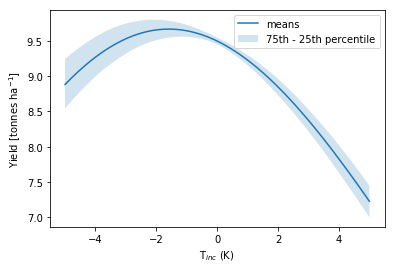

In [48]:

plt.plot(T_incs_corr, sample2_means, label='means')
#plt.plot(T_incs, sample_medians, label='medians')
#plt.plot(T_incs, sample_25, label='25th percentile')
#plt.plot(T_incs, sample_75, label='75th percentile')
plt.fill_between(T_incs_corr, sample2_25, sample2_75, label='75th - 25th percentile', alpha=0.2)
plt.legend()
plt.xlabel('T$_{{inc}}$ (K)')
plt.ylabel('Yield [tonnes ha$^{-1}$]')
plt.savefig('./figs/temperature_impact2_m5p5.pdf')
plt.savefig('./figs/temperature_impact2_m5p5.png')

In [49]:
#                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
#mu_t               19.67    0.02   0.72  18.09  19.24  19.74  20.18  20.93   1036    1.0
#sigma_t             5.23    0.02   0.57   4.32   4.83   5.17   5.57   6.53    797    1.0
#mu_p              115.07    0.11   4.12 106.99 112.34 115.12 117.78 123.13   1443    1.0
#sigma_p            62.62    0.08   2.82  57.36  60.63  62.57   64.5  68.19   1358    1.0
#rho                -0.02  2.0e-3   0.08  -0.17  -0.07  -0.02   0.03   0.13   1433    1.0
#norm                1.56  2.1e-3   0.07   1.44   1.51   1.56    1.6   1.69    973    1.0

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


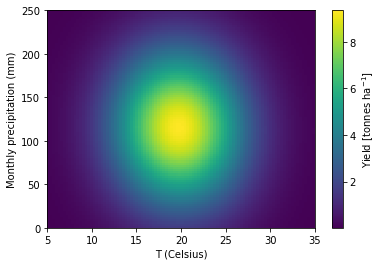

In [50]:


fig, ax = plt.subplots()

t1, t2 = 5., 35.
p1, p2 = 0., 250.
x = np.linspace(t1,t2,100.)
y = np.linspace(p1,p2,100.)
X,Y = meshgrid(x, y) # grid of point
def yield_equal2(temp, precip, mu_t, sigma_t, mu_p, sigma_p, rho, norm):
    """Take six months of T and P and return yield for given params.
    
    This should be identical to the function in the STAN model
    """
    temp_6m = np.full(6, temp)
    precip_6m = np.full(6, precip)
    if len(norm) == 1:
        norm = norm * np.ones(6)
    dy = np.zeros(6)
    for month in np.arange(6):
        dy[month] = norm[month]*np.exp(-(1/(2 - 2*rho**2)) *( np.square((temp_6m[month]    - mu_t)/sigma_t) 
                                                           + np.square((precip_6m[month] - mu_p)/sigma_p) 
                                                           - (2*rho*(temp_6m[month]    - mu_t)
                                                                   *(precip_6m[month] - mu_p)
                                                             )
                                                              /(sigma_t*sigma_p)
                                                           )
                                      )
    return np.sum(dy)
def z_func(X,Y):
    return yield_equal2(X, Y, 19.74, 5.17, 115.12, 62.57, -0.02, [1.56])
z_func = np.vectorize(z_func)
#Lets use the median

Z = z_func(X, Y) # evaluation of the function on the grid

im = ax.imshow(np.flip(Z, axis=0),cmap="viridis", extent=[t1,t2,p1,p2], aspect="auto") # drawing the function
# adding the Contour lines with labels
#cset = contour(Z,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2)
#clabel(cset,inline=True,fmt='%1.1f',fontsize=10)

cbar = fig.colorbar(im) # adding the colobar on the right
cbar.set_label('Yield [tonnes ha$^{-1}$]')
# latex fashion title
#title('$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$')

ax.set_xlabel('T (Celsius)')
ax.set_ylabel('Monthly precipitation (mm)')

plt.savefig('./figs/2d_2.pdf')
plt.savefig('./figs/2d_2.png')

In [51]:
data2['d_precip']

array([[[ 75.25291753,  85.83683791, 133.44429417, 109.26561872,
         137.0134282 ,  77.79794749],
        [149.54253603, 173.75202661, 125.11506518, 131.02297284,
         102.20628622,  97.21814035],
        [ 56.44104887, 123.62218878, 107.43842577,  98.07348464,
          84.64356708,  58.22764308],
        ...,
        [ 70.29394894,  86.63458033,  25.41465675,  77.06708532,
          97.02873585, 138.82704216],
        [176.43561756, 119.985384  , 149.03634517, 105.14860626,
          71.01551827,  65.76953295],
        [141.11174954, 120.43960547, 166.33686622,  80.6756401 ,
         131.67100444,  92.48618428]],

       [[ 64.93835524,  81.33833423, 113.28620661,  91.90444217,
         142.41877647, 121.70702232],
        [142.55719903, 151.73163468, 132.87625895, 164.63142815,
         150.76911885,  83.358952  ],
        [ 69.62338591, 135.0633929 , 101.42119788, 156.0985889 ,
          90.81889853,  66.76183226],
        ...,
        [100.319296  ,  92.822115  ,  28.1766

## Now lets plot a response in temperature and precipitation space

In [52]:
T_incs_2 = np.linspace(-10, 10, 50)
P_incs_2 = np.linspace(-100, 100, 50)
T_P_grid = np.meshgrid(T_incs_2, P_incs_2)

In [53]:
def yield_anomaly2(temp_6m, precip_6m, mu_t, sigma_t, mu_p, sigma_p, rho, norm):
    """Take six months of T and P and return yield for given params.
    
    This should be identical to the function in the STAN model
    """
    if len(norm) == 1:
        norm = norm * np.ones(6)
    dy = np.zeros(6)
    for month in np.arange(6):
        dy[month] = norm[month]*np.exp(-(1/(2 - 2*rho*2)) *( np.square((temp_6m[month]    - mu_t)/sigma_t) 
                                                           + np.square((precip_6m[month] - mu_p)/sigma_p) 
                                                           - (2*rho*(temp_6m[month]    - mu_t)
                                                                   *(precip_6m[month] - mu_p)
                                                             )
                                                              /(sigma_t*sigma_p)
                                                           )
                                      )
                                      
    return np.sum(dy)

def compute_mean_yield_anomaly3(T_inc, P_inc, data, mu_t, sigma_t, mu_p, sigma_p, rho, norm):
    """ Compute mean yield anomaly for a model over regions and years
    
    The function yield_anomaly returens the yield anomaly for a year 
    and and region. Here we loop over the regions and years to create
    and overall mean.
    
    """
    
    yield_anomalies = np.full((6, 35), np.nan)
    #loop over states
    for state in np.arange(6):
        #loop over years
        for year in np.arange(35):
            temp_6m = data['d_temp'][state, year, :] + T_inc
            precip_6m = data['d_precip'][state, year, :] + P_inc
            yield_anomalies[state, year] = yield_anomaly2(temp_6m, 
                                                         precip_6m, 
                                                         mu_t, 
                                                         sigma_t, 
                                                         mu_p, 
                                                         sigma_p,
                                                         rho, 
                                                         norm)
    
    return np.nanmean(yield_anomalies)

In [54]:
take_100 = np.random.choice([0,1], 
                            size=len(samples2['mu_t']), 
                            p=(1-100/len(samples2['mu_t']), 100/len(samples2['mu_t'])))


In [55]:
mean_yield_anom = np.full((len(T_incs_2), len(P_incs_2)), np.nan)

for n, t in enumerate(T_incs_2):
    print("{} out of {}".format(n, len(T_incs_2)))
    for m, p in enumerate(P_incs_2):
        mean_yield_samples = np.full(len(samples2['mu_t']), np.nan)
        for k in np.arange(len(samples2['mu_t'])):
            if not take_100[k]:
                continue
            
            #print('k = {}'.format(k))
            mu_t    = samples2['mu_t'][k]
            sigma_t = samples2['sigma_t'][k]
            mu_p    = samples2['mu_p'][k]
            sigma_p = samples2['sigma_p'][k]
            rho = samples2['rho'][k]
            norm    = [samples2['norm'][k]]

            mean_yield_samples[k] = compute_mean_yield_anomaly3(t, p, data2, mu_t, sigma_t, mu_p, sigma_p, rho, norm)
        
        mean_yield_anom[n, m] = np.nanmean(mean_yield_samples)

0 out of 50
1 out of 50
2 out of 50
3 out of 50
4 out of 50
5 out of 50
6 out of 50
7 out of 50
8 out of 50
9 out of 50
10 out of 50
11 out of 50
12 out of 50
13 out of 50
14 out of 50
15 out of 50
16 out of 50
17 out of 50
18 out of 50
19 out of 50
20 out of 50
21 out of 50
22 out of 50
23 out of 50
24 out of 50
25 out of 50
26 out of 50
27 out of 50
28 out of 50
29 out of 50
30 out of 50
31 out of 50
32 out of 50
33 out of 50
34 out of 50
35 out of 50
36 out of 50
37 out of 50
38 out of 50
39 out of 50
40 out of 50
41 out of 50
42 out of 50
43 out of 50
44 out of 50
45 out of 50
46 out of 50
47 out of 50
48 out of 50
49 out of 50


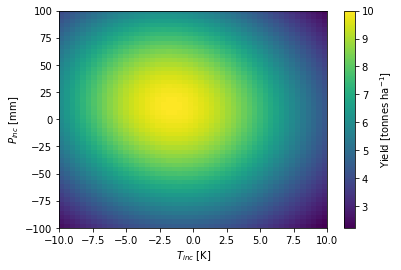

In [56]:



fig, ax = plt.subplots()


im = imshow(np.flip(mean_yield_anom.T, axis=0),cmap="viridis", 
            extent=[T_incs_2[0],T_incs_2[-1], P_incs_2[0], P_incs_2[-1]], 
            aspect="auto") # drawing the function
# adding the Contour lines with labels
#cset = contour(Z,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2)
#clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
cbar = fig.colorbar(im) # adding the colobar on the right
cbar.set_label('Yield [tonnes ha$^{-1}$]')
# latex fashion title
#title('$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$')

ax.set_xlabel('$T_{inc}$ [K]')
ax.set_ylabel('$P_{inc}$ [mm]')

plt.savefig('./figs/temp_precip_impact.pdf')
plt.savefig('./figs/temp_precip_impact.png')


## Plot posteriors

In [60]:
samples = samples2

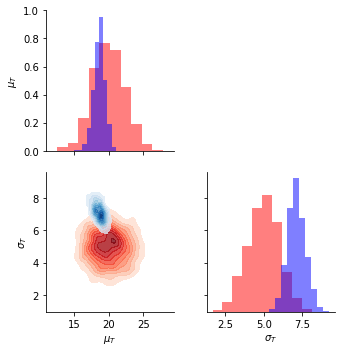

In [61]:
df=pd.DataFrame(np.random.multivariate_normal(np.array([20,5]),np.array([[5.0,0.0],[0.0,1.0]]),2000),
                columns=['$\mu_T$','$\sigma_T$'])
g=sns.PairGrid(data=df,size=2.5,diag_sharey=False)
g.map_diag(plt.hist,color='Red',alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Reds",alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)
df=pd.DataFrame(np.vstack((samples['mu_t'],samples['sigma_t'])).T,columns=['$\mu_T$','$\sigma_T$'])
g.data=df
g.map_diag(plt.hist,color='Blue',alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Blues",alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)

g.axes[0,1].set_axis_off()

#fig = g.get_figure()
plt.savefig("./figs/2d_Gauss_prior_vs_post_temp_mean_vs_sigma.png")
plt.savefig("./figs/2d_Gauss_prior_vs_post_temp_mean_vs_sigma.pdf")

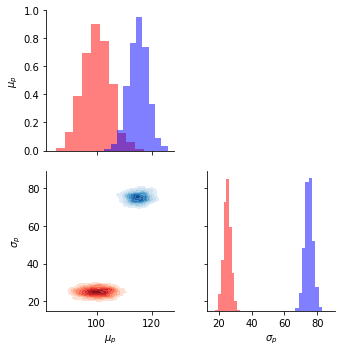

In [62]:
df=pd.DataFrame(np.random.multivariate_normal(np.array([100,25]),np.array([[25.0,0.0],[0.0,5.0]]),2000),
                columns=['$\mu_p$','$\sigma_p$'])
g=sns.PairGrid(data=df,size=2.5,diag_sharey=False)
g.map_diag(plt.hist,color='Red',alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Reds",alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)
df=pd.DataFrame(np.vstack((samples['mu_p'],samples['sigma_p'])).T,columns=['$\mu_p$','$\sigma_p$'])

g.data=df
g.map_diag(plt.hist,color='Blue',alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Blues",alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)

g.axes[0,1].set_axis_off()

#fig = g.get_figure()
plt.savefig("./figs/2d_Gauss_prior_vs_post_precip_mean_vs_sigma.png")
plt.savefig("./figs/2d_Gauss_prior_vs_post_precip_mean_vs_sigma.pdf")

## Pvals

In [63]:
def Bayesian_Pval(yields,pred_yields):
    import scipy.stats as st
    Pvals=np.empty_like(yields)
    n_reg,n_years=yields.shape
    for r in range(0,n_reg):
        for y in range(0,n_years):
            ind=pred_yields[:,r,y]<yields[r,y]
            Pvals[r,y]=st.norm.ppf(ind.sum()/pred_yields[:,r,y].size)
    return Pvals

In [64]:
Pvals=Bayesian_Pval(fit2.data['d_yields'],samples2['pred_yields'])

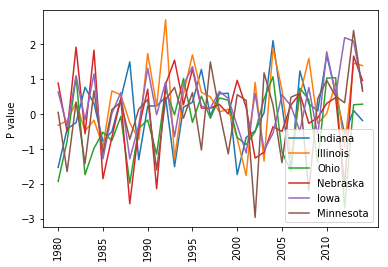

In [65]:
#plt.figure(figsize=(10,5))
for s in range(0,len(states)):
    plt.plot(Pvals[s,:],label=states[s])
plt.xticks(5*np.arange(len(np.arange(1980,2015, 5))),np.arange(1980,2015, 5),rotation=90);
plt.legend()
plt.ylabel('P value')

plt.savefig("./figs/pvalues_all.png".format(states[s]))
plt.savefig("./figs/pvalues_all.pdf".format(states[s]))